# Install QSPRpred

In [ ]:
%pip install git+https://github.com/CDDLeiden/QSPRPred.git@main

# Create your dataset

## Fetching data from Papyrus

In [17]:
### SKIP THIS CELL ###

from qsprpred.data.sources.papyrus import Papyrus

acc_keys = ["P29274"] # Specify the protein accession key(s) of your target(s) of interest
dataset_name = "A2AR_data"  # name of the file to be generated
quality = "high"  # choose minimum quality from {"high", "medium", "low"}
papyrus_version = '05.6'  # Papyrus database version
data_dir = "data"

papyrus = Papyrus(
    data_dir=data_dir,
    version=papyrus_version,
    stereo=False,
    plus_only=True, # Set to False to include lower quality data
)

mt = papyrus.getData(
    acc_keys,
    quality,
    name=dataset_name,
    use_existing=True,
    activity_types=["Ki", "IC50", "Kd"]
)
mt

########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 9
Total size: 7.43GB


Reading data from data...
Read all data.
Initialized filters.


0it [00:00, ?it/s]

Number of compounds:4082
Wrote data to file 'data\A2AR_data.tsv'.


In [2]:
from qsprpred.data.data import MoleculeTable

mt = MoleculeTable.fromFile("data/A2AR_data.pkl")

In [3]:
mt.getDF()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,TID,accession,Protein_Type,AID,doc_id,Year,all_doc_ids,all_years,type_IC50,type_EC50,type_KD,type_Ki,type_other,Activity_class,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD,QSPRID,pchembl_value_Median_class,Split_IsTrain
QSPRID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A2AR_data_0,AACWUFIIMOHGSO_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.91968,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,AACWUFIIMOHGSO,AACWUFIIMOHGSO-UHFFFAOYSA-N,InChI=1S/C19H24N6O2/c1-12-10-13(2)25(23-12)17-...,"""AuxInfo=1/1/N:1,26,22,14,15,20,19,11,12,27,6,...",P29274_WT,ChEMBL:CHEMBL251,P29274,WT,CHEMBL949247,PMID:18307293,2008.0,PMID:18307293,2008,0,0,0,1,NaN,NaN,=,8.68,8.680,0.000000,0.000000,1.0,8.680,0.000,A2AR_data_0,True,True
A2AR_data_1,AAEYTMMNWWKSKZ_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.131451,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2nc3c(cc12...,AAEYTMMNWWKSKZ,AAEYTMMNWWKSKZ-UHFFFAOYSA-N,InChI=1S/C18H16N4O3S/c19-15-13-9-10-3-1-2-4-14...,"""AuxInfo=1/1/N:22,23,21,24,8,15,9,14,19,20,7,1...",P29274_WT,ChEMBL:CHEMBL251,P29274,WT,CHEMBL1071493,PMID:20095623,2010.0,PMID:20095623,2010,0,0,0,1,NaN,NaN,=,4.82,4.820,0.000000,0.000000,1.0,4.820,0.000,A2AR_data_1,False,False
A2AR_data_2,AAGFKZWKWAMJNP_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.100375,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,AAGFKZWKWAMJNP,AAGFKZWKWAMJNP-UHFFFAOYSA-N,InChI=1S/C21H14N6O2/c28-20(14-8-3-1-4-9-14)24-...,"""AuxInfo=1/1/N:27,19,26,28,18,20,9,25,29,17,21...",P29274_WT,ChEMBL:CHEMBL251,P29274,WT,CHEMBL1012738,PMID:19301821,2009.0,PMID:19301821,2009,0,0,0,1,NaN,NaN,=,5.65,5.650,0.000000,0.000000,1.0,5.650,0.000,A2AR_data_2,False,True
A2AR_data_3,AANUKDYJZPKTKN_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.123484,CNC(=O)C12CC1C(n1cnc3c(NCc4cccc(Cl)c4)nc(C#CCC...,AANUKDYJZPKTKN,AANUKDYJZPKTKN-UHFFFAOYSA-N,InChI=1S/C28H31ClN6O5/c1-30-27(39)28-13-18(28)...,"""AuxInfo=1/1/N:1,25,18,19,17,20,35,36,34,16,21...",P29274_WT,ChEMBL:CHEMBL251;EntrezID:135,P29274,WT,CHEMBL1052240,PMID:19499950,2009.0,PMID:19499950,2009,0,0,0,1,NaN,NaN,=,5.45,5.450,0.000000,0.000000,1.0,5.450,0.000,A2AR_data_3,False,False
A2AR_data_4,AASXHCGIIQCKEE_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.419145,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,AASXHCGIIQCKEE,AASXHCGIIQCKEE-UHFFFAOYSA-N,InChI=1S/C24H27N5O6S/c1-4-12-29-23(31)20-21(26...,"""AuxInfo=1/1/N:1,14,30,2,20,26,34,27,33,15,21,...",P29274_WT,ChEMBL:CHEMBL251,P29274,WT,CHEMBL4392067,PMID:30869893,2019.0,PMID:30869893,2019,0,0,0,1,NaN,NaN,=,5.2,5.200,0.000000,0.000000,1.0,5.200,0.000,A2AR_data_4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A2AR_data_4077,ZPOFECDYIXUBJD_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.105475,COc1cncc(-c2cc(NC(C)=O)nc(-n3nc(C)cc3C)n2)c1,ZPOFECDYIXUBJD,ZPOFECDYIXUBJD-UHFFFAOYSA-N,InChI=1S/C17H18N6O2/c1-10-5-11(2)23(22-10)17-2...,"""AuxInfo=1/1/N:18,21,11,1,19,4,7,23,25,17,20,1...",P29274_WT,ChEMBL:CHEMBL251;ChEMBL:CHEMBL251;ChEMBL:CHEMB...,P29274,WT,CHEMBL987749;CHEMBL950440;CHEMBL987748,PMID:18947224,2008.0,PMID:19140664;PMID:18947224;PMID:19140664,2009;2008;2009,1;1;0,0,0,0;0;1,NaN,NaN,=,7.07;7.24;8.64,7.650,0.861568,0.497427,3.0,7.240,0.170,A2AR_data_4077,True,False
A2AR_data_4078,ZRVXKIGWMZOKNP_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.217654;ChEMBL31.compound.5447,CCNC(=O)C1OC(n2cnc3c(NCCCCCCCCCCNc4ccc([N+](=O...,ZRVXKIGWMZOKNP,ZRVXKIGWMZOKNP-UHFFFAOYSA-N,InChI=1S/C28H38N10O7/c1-2-29-27(41)24-22(39)23...,"""AuxInfo=1/1/N:1,2,24,23,25,22,26,21,27,20,31,...",P29274_WT,EntrezID:135;EntrezID:135;ChEMBL:CHEMBL251;ChE...,P29274,WT,CHEMBL2417084;CHEMBL641569,PMID:11714602,2001.0,PMID:23200243;PMID:11714602,2013;2001,0,0,0,1,NaN,NaN,=,5.21;5.21,5.210,0.000000,0.000000,2.0,5.210,0.000,A2AR_data_4078,False,False
A2AR_data_4079,ZVQWUWX

## Preparing data for modelling

In [4]:
from qsprpred.models.tasks import TargetTasks
from qsprpred.data.data import QSPRDataset

target_props=[{
                "name": "pchembl_value_Median", # name of the target column in the dataset
                "task": TargetTasks.REGRESSION, # specify the task type (SINGLECLASS, MULTICLASS, REGRESSION)
                }]

# Create a QSPRDataset instance used for training and evaluation of QSPR models
dataset = QSPRDataset.fromMolTable(mt, target_props=target_props)
dataset.targetProperties

c:\Users\helle\anaconda3\envs\ulla2023\Lib\site-packages\qsprpred\data\data.py:552: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  super().__init__(name, df, store_dir, overwrite, index_cols, n_jobs, chunk_size)


[TargetProperty(name=pchembl_value_Median, task=REGRESSION)]

![descriptors](figures/descriptors_small.png)

In [5]:
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import RandomSplit

# Calculate MorganFP and physicochemical properties
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (80%) and test set (20%)
rand_split = RandomSplit(0.2)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
    feature_standardizer=Scaler()
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

# Let's save the dataset for later
dataset.save()

Molecular descriptors already exist in A2AR_data. Use `recalculate=True` to overwrite them.
Missing values filled with nan


Number of samples train set: 3265
Number of samples test set: 817


# Training a ML model

In [34]:
N_CPU = 4 # number of CPUs for parallel operations

In [6]:
from qsprpred.models.models import QSPRsklearn
from sklearn.cross_decomposition import PLSRegression
from qsprpred.models.hyperparam_optimization import OptunaOptimization

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
model = QSPRsklearn(base_dir = '.', data=dataset, alg = PLSRegression, name='PLS_REG')

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
# the best hyperparameter combination will be saved in PLS_REG_params.json
search_space_bs = {"n_components": ["int", 1, 30], "scale": ["categorical", [True, False]]}
bayesoptimizer = OptunaOptimization(scoring = model.scoreFunc, param_grid=search_space_bs, n_trials=5)
best_params = bayesoptimizer.optimize(model)

#Then we will evaluate the performance of the best model using the independent test set
_ = model.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
# model is saved under qspr/models/PLS_REG.json
model.fit()

At the moment n_jobs>1 not available for bayes optimization, n_jobs set to 1.
[I 2023-06-27 10:47:56,944] A new study created in memory with name: no-name-0371b62d-c481-4288-be44-68a4542ad7a9
[I 2023-06-27 10:48:03,209] Trial 0 finished with value: 0.202440742255524 and parameters: {'n_components': 30, 'scale': True}. Best is trial 0 with value: 0.202440742255524.
[I 2023-06-27 10:48:04,382] Trial 1 finished with value: 0.4276938091872433 and parameters: {'n_components': 1, 'scale': False}. Best is trial 1 with value: 0.4276938091872433.
[I 2023-06-27 10:48:05,653] Trial 2 finished with value: 0.5299214142999747 and parameters: {'n_components': 2, 'scale': False}. Best is trial 2 with value: 0.5299214142999747.
[I 2023-06-27 10:48:08,707] Trial 3 finished with value: 0.5262240015417234 and parameters: {'n_components': 12, 'scale': False}. Best is trial 2 with value: 0.5299214142999747.
[I 2023-06-27 10:48:10,999] Trial 4 finished with value: 0.5779965244149661 and parameters: {'n_compo

'./qspr/models/PLS_REG/PLS_REG_meta.json'

<Axes: title={'center': 'PLS_REG (PLSRegression)'}, xlabel='Experimental pchembl_value_Median', ylabel='Predicted pchembl_value_Median'>

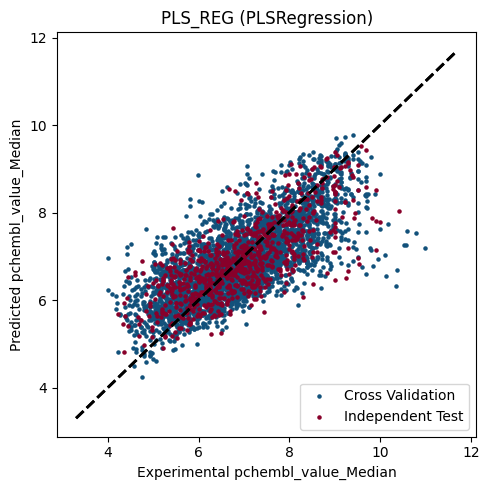

In [8]:
from qsprpred.plotting.regression import CorrelationPlot

plt = CorrelationPlot([model])
axes, summary = plt.make(save=False, property_name='pchembl_value_Median')
axes[0]

# Make predictions for your own compound

Missing values filled with nan


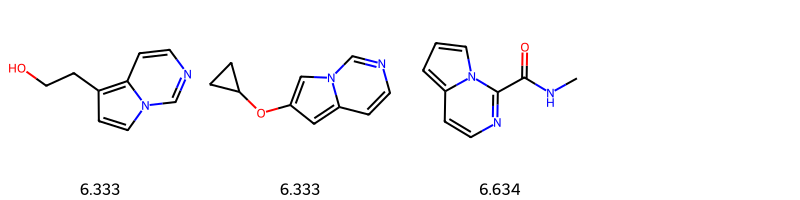

In [20]:
# replace with your own compounds
list_of_smiles = ['OCCc1ccn2cnccc12',
                  'C1CC1Oc1cc2ccncn2c1',
                  'CNC(=O)c1nccc2cccn12']

# make predictions with the model
predictions = model.predictMols(list_of_smiles)

# show molecules with predicted values using rdkit
from rdkit import Chem
from rdkit.Chem import Draw
 
mols = [Chem.MolFromSmiles(smi) for smi in list_of_smiles]
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=[f'{pred[0]:.3f}' for pred in predictions])